**第6章: 機械学習**

50. データの入手・整形

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2025-01-16 17:29:41--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘NewsAggregatorDataset.zip.1’

NewsAggregatorDatas     [   <=>              ]  27.87M  65.8MB/s    in 0.4s    

2025-01-16 17:29:41 (65.8 MB/s) - ‘NewsAggregatorDataset.zip.1’ saved [29224203]

Archive:  NewsAggregatorDataset.zip
replace 2pageSessions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!wc -l newsCorpora.csv

422937 newsCorpora.csv


In [ ]:
!head -10 newsCorpora.csv

1	Fed official says weak data caused by weather, should not slow taper	http://www.latimes.com/business/money/la-fi-mo-federal-reserve-plosser-stimulus-economy-20140310,0,1312750.story\?track=rss	Los Angeles Times	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.latimes.com	1394470370698
2	Fed's Charles Plosser sees high bar for change in pace of tapering	http://www.livemint.com/Politics/H2EvwJSK2VE6OF7iK1g3PP/Feds-Charles-Plosser-sees-high-bar-for-change-in-pace-of-ta.html	Livemint	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.livemint.com	1394470371207
3	US open: Stocks fall after Fed official hints at accelerated tapering	http://www.ifamagazine.com/news/us-open-stocks-fall-after-fed-official-hints-at-accelerated-tapering-294436	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.ifamagazine.com	1394470371550
4	Fed risks falling 'behind the curve', Charles Plosser says	http://www.ifamagazine.com/news/fed-risks-falling-behind-the-curve-charles-plosser-says-294430	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www

In [ ]:
# 読込時のエラー回避のためダブルクォーテーションをシングルクォーテーションに置換
!sed -e 's/"/'\''/g' newsCorpora.csv > newsCorpora_re.csv

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

# データの保存
train.to_csv('train.txt', sep='\t', index=False)
valid.to_csv('valid.txt', sep='\t', index=False)
test.to_csv('test.txt', sep='\t', index=False)

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
CATEGORY
b    4501
e    4235
t    1220
m     728
Name: count, dtype: int64
【検証データ】
CATEGORY
b    563
e    529
t    153
m     91
Name: count, dtype: int64
【評価データ】
CATEGORY
b    563
e    530
t    152
m     91
Name: count, dtype: int64


In [ ]:
! wc -l "train.txt"
! wc -l "test.txt"
! wc -l "valid.txt"

10685 train.txt
1337 test.txt
1337 valid.txt


51. 特徴量抽出

In [3]:
import string
import re

def preprocessing(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  text = text.translate(table)  # 記号をスペースに置換
  text = text.lower()  # 小文字化
  text = re.sub('[0-9]+', '0', text)  # 数字列を0に置換

  return text

In [4]:
# データの再結合
df = pd.concat([train, valid, test], axis=0)
df.reset_index(drop=True, inplace=True)  # indexを振りなおす

# 前処理の実施
df['TITLE'] = df['TITLE'].map(lambda x: preprocessing(x))

df.head()

,TITLE,CATEGORY
0,refile update 0 european car sales up for sixt...,b
1,amazon plans to fight ftc over mobile app purc...,t
2,kids still get codeine in emergency rooms desp...,m
3,what on earth happened between solange and jay...,e
4,nato missile defense is flight tested over hawaii,b


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# データの分割
train_valid, test = df[:len(train) + len(valid)], df[len(train) + len(valid):]

# TfidfVectorizer
vec_tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2))

# ベクトル化
X_train_valid = vec_tfidf.fit_transform(train_valid['TITLE'])  # testの情報は使わない
X_test = vec_tfidf.transform(test['TITLE'])

# ベクトルをデータフレームに変換
X_train_valid = pd.DataFrame(X_train_valid.toarray(), columns=vec_tfidf.get_feature_names_out())
X_test = pd.DataFrame(X_test.toarray(), columns=vec_tfidf.get_feature_names_out())

# データの分割
X_train = X_train_valid[:len(train)]
X_valid = X_train_valid[len(train):]

# データの保存
X_train.to_csv('X_train.txt', sep='\t', index=False)
X_valid.to_csv('X_valid.txt', sep='\t', index=False)
X_test.to_csv('X_test.txt', sep='\t', index=False)

X_train.head(200)

,0m,0million,0nd,0s,0st,0th,0th birthday,aa,aaliyah,abbvie,...,young,your,your mother,yr,yr high,yuan,zac,zac efron,zendaya,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
print(X_train.shape)

(10684, 2815)


52. 学習

In [6]:
from sklearn.linear_model import LogisticRegression

# モデルの学習
lg = LogisticRegression(random_state=123, max_iter=10000)
lg.fit(X_train, train['CATEGORY'])

LogisticRegression(max_iter=10000, random_state=123)

53. 予測

In [7]:
import numpy as np

def score_lg(lg, X):
  return [np.max(lg.predict_proba(X), axis=1), lg.predict(X)]

In [8]:
train_pred = score_lg(lg, X_train)
test_pred = score_lg(lg, X_test)

train_pred

[array([0.84303449, 0.6810275 , 0.55995448, ..., 0.86187183, 0.61549106,
        0.9078752 ]),
 array(['b', 't', 'm', ..., 'b', 'm', 'e'], dtype=object)]

54. 正解率の計測

In [9]:
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(train['CATEGORY'], train_pred[1])
test_accuracy = accuracy_score(test['CATEGORY'], test_pred[1])
print(f'正解率（学習データ）：{train_accuracy:.3f}')
print(f'正解率（評価データ）：{test_accuracy:.3f}')

正解率（学習データ）：0.926
正解率（評価データ）：0.885


55. 混同行列の作成

[[4344   93    8   56]
 [  52 4172    2    9]
 [  96  126  493   13]
 [ 192  135    6  887]]


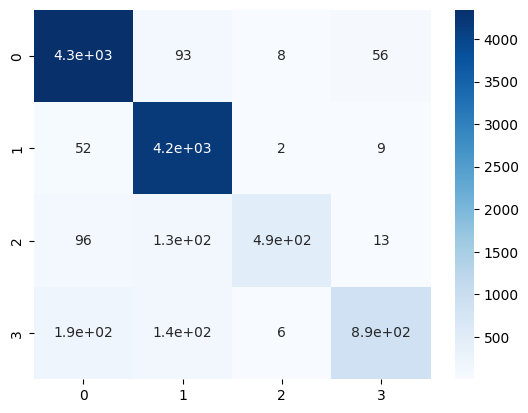

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 学習データ
train_cm = confusion_matrix(train['CATEGORY'], train_pred[1])
print(train_cm)
sns.heatmap(train_cm, annot=True, cmap='Blues')
plt.show()

[[529  19   2  13]
 [ 12 515   1   2]
 [ 11  27  51   2]
 [ 37  26   1  88]]


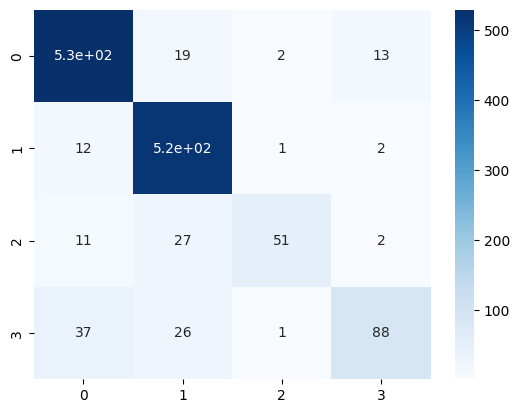

In [16]:
# 評価データ
test_cm = confusion_matrix(test['CATEGORY'], test_pred[1])
print(test_cm)
sns.heatmap(test_cm, annot=True, cmap='Blues')
plt.show()

56. 適合率，再現率，F1スコアの計測

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_scores(y_true, y_pred):
  # 適合率
  precision = precision_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm'])  # Noneを指定するとクラスごとの精度をndarrayで返す
  precision = np.append(precision, precision_score(y_true, y_pred, average='micro'))  # 末尾にマイクロ平均を追加
  precision = np.append(precision, precision_score(y_true, y_pred, average='macro'))  # 末尾にマクロ平均を追加

  # 再現率
  recall = recall_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm'])
  recall = np.append(recall, recall_score(y_true, y_pred, average='micro'))
  recall = np.append(recall, recall_score(y_true, y_pred, average='macro'))

  # F1スコア
  f1 = f1_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm'])
  f1 = np.append(f1, f1_score(y_true, y_pred, average='micro'))
  f1 = np.append(f1, f1_score(y_true, y_pred, average='macro'))

  # 結果を結合してデータフレーム化
  scores = pd.DataFrame({'適合率': precision, '再現率': recall, 'F1スコア': f1},
                        index=['b', 'e', 't', 'm', 'マイクロ平均', 'マクロ平均'])

  return scores


In [18]:
pd.options.display.precision = 3  # 小数点以下3桁まで表示
calculate_scores(test['CATEGORY'], test_pred[1])

,適合率,再現率,F1スコア
b,0.898,0.940,0.918
e,0.877,0.972,0.922
t,0.838,0.579,0.685
m,0.927,0.560,0.699
マイクロ平均,0.885,0.885,0.885
マクロ平均,0.885,0.763,0.806


57. 特徴量の重みの確認

In [19]:
features = X_train.columns.values
index = [i for i in range(1, 11)]
for c, coef in zip(lg.classes_, lg.coef_):
  print(f'【カテゴリ】{c}')
  best10 = pd.DataFrame(features[np.argsort(coef)[::-1][:10]], columns=['重要度上位'], index=index).T
  worst10 = pd.DataFrame(features[np.argsort(coef)[:10]], columns=['重要度下位'], index=index).T
  display(pd.concat([best10, worst10], axis=0))
  print('\n')

【カテゴリ】b


,1,2,3,4,5,6,7,8,9,10
重要度上位,bank,fed,china,ecb,stocks,euro,obamacare,oil,yellen,dollar
重要度下位,video,ebola,the,her,and,she,apple,google,microsoft,star




【カテゴリ】e


,1,2,3,4,5,6,7,8,9,10
重要度上位,kardashian,chris,her,movie,star,film,paul,he,wedding,she
重要度下位,us,update,google,study,china,gm,ceo,facebook,apple,says




【カテゴリ】m


,1,2,3,4,5,6,7,8,9,10
重要度上位,ebola,study,cancer,drug,mers,fda,cases,cdc,could,cigarettes
重要度下位,facebook,gm,ceo,apple,bank,deal,google,sales,climate,twitter




【カテゴリ】t


,1,2,3,4,5,6,7,8,9,10
重要度上位,google,facebook,apple,microsoft,climate,gm,nasa,tesla,comcast,heartbleed
重要度下位,stocks,fed,her,percent,drug,american,cancer,ukraine,still,shares


58. 正則化パラメータの変更

In [20]:
from tqdm import tqdm

result = []
for C in tqdm(np.logspace(-5, 4, 10, base=10)):
  # モデルの学習
  lg = LogisticRegression(random_state=123, max_iter=10000, C=C)
  lg.fit(X_train, train['CATEGORY'])

  # 予測値の取得
  train_pred = score_lg(lg, X_train)
  valid_pred = score_lg(lg, X_valid)
  test_pred = score_lg(lg, X_test)

  # 正解率の算出
  train_accuracy = accuracy_score(train['CATEGORY'], train_pred[1])
  valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred[1])
  test_accuracy = accuracy_score(test['CATEGORY'], test_pred[1])

  # 結果の格納
  result.append([C, train_accuracy, valid_accuracy, test_accuracy])

100%|██████████| 10/10 [01:58<00:00, 11.89s/it]


In [21]:
print(result)

[[9.999999999999999e-06, 0.42128416323474355, 0.4214071856287425, 0.4214071856287425], [9.999999999999999e-05, 0.42128416323474355, 0.4214071856287425, 0.4214071856287425], [0.001, 0.4731374017222014, 0.4655688622754491, 0.48278443113772457], [0.01, 0.7606701609883939, 0.7597305389221557, 0.7537425149700598], [0.09999999999999999, 0.8043803818794459, 0.7919161676646707, 0.7979041916167665], [1.0, 0.9262448521153126, 0.8779940119760479, 0.8854790419161677], [10.0, 0.9776301010857357, 0.8877245508982036, 0.8907185628742516], [100.0, 0.9968176712841632, 0.8690119760479041, 0.8705089820359282], [1000.0, 0.9980344440284538, 0.8600299401197605, 0.8705089820359282], [10000.0, 0.9980344440284538, 0.8600299401197605, 0.874251497005988]]


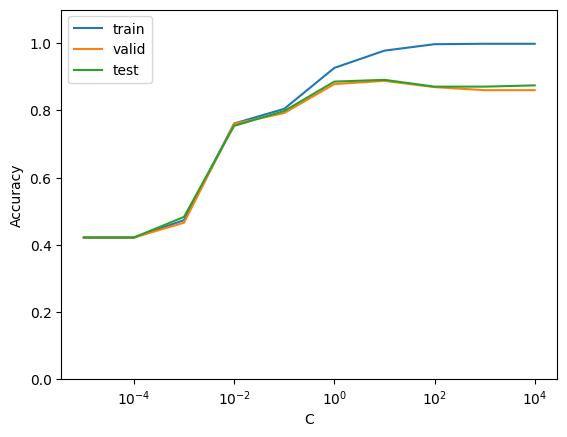

In [22]:
# 視覚化
result = np.array(result).T
plt.plot(result[0], result[1], label='train')
plt.plot(result[0], result[2], label='valid')
plt.plot(result[0], result[3], label='test')
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.xscale ('log')
plt.xlabel('C')
plt.legend()
plt.show()


59. ハイパーパラメータの探索

In [1]:
!pip install xgboost==1.7.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 5.1 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.3
    Uninstalling xgboost-2.1.3:
      Successfully uninstalled xgboost-2.1.3


In [ ]:
import xgboost as xgb

params={'objective': 'multi:softmax',
        'num_class': 4,
        'eval_metric': 'mlogloss',
        'colsample_bytree': 1.0,
        'colsample_bylevel': 0.5,
        'min_child_weight': 1,
        'subsample': 0.9,
        'eta': 0.1,
        'max_depth': 5,
        'gamma': 0.0,
        'alpha': 0.0,
        'lambda': 1.0,
        'num_round': 1000,
        'early_stopping_rounds': 50,
        'verbosity': 0
        }

# Xgboost用にフォーマット変換
category_dict = {'b': 0, 'e': 1, 't':2, 'm':3}
y_train = train['CATEGORY'].map(lambda x: category_dict[x])
y_valid = valid['CATEGORY'].map(lambda x: category_dict[x])
y_test = test['CATEGORY'].map(lambda x: category_dict[x])
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_test, label=y_test)

# 学習
num_round = params.pop('num_round')
early_stopping_rounds = params.pop('early_stopping_rounds')
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
model = xgb.train(params, dtrain, num_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds)

[0]	train-mlogloss:1.32709	eval-mlogloss:1.32675
[1]	train-mlogloss:1.27527	eval-mlogloss:1.27415
[2]	train-mlogloss:1.23120	eval-mlogloss:1.23033
[3]	train-mlogloss:1.19221	eval-mlogloss:1.19072
[4]	train-mlogloss:1.15729	eval-mlogloss:1.15568
[5]	train-mlogloss:1.12565	eval-mlogloss:1.12319
[6]	train-mlogloss:1.09730	eval-mlogloss:1.09517
[7]	train-mlogloss:1.07188	eval-mlogloss:1.06918
[8]	train-mlogloss:1.04904	eval-mlogloss:1.04648
[9]	train-mlogloss:1.02800	eval-mlogloss:1.02533
[10]	train-mlogloss:1.00857	eval-mlogloss:1.00581
[11]	train-mlogloss:0.99137	eval-mlogloss:0.98858
[12]	train-mlogloss:0.97566	eval-mlogloss:0.97245
[13]	train-mlogloss:0.96062	eval-mlogloss:0.95791
[14]	train-mlogloss:0.94702	eval-mlogloss:0.94425
[15]	train-mlogloss:0.93418	eval-mlogloss:0.93221
[16]	train-mlogloss:0.92193	eval-mlogloss:0.92048
[17]	train-mlogloss:0.91032	eval-mlogloss:0.90908
[18]	train-mlogloss:0.89992	eval-mlogloss:0.89889
[19]	train-mlogloss:0.89006	eval-mlogloss:0.88998
[20]	train

In [ ]:
# 予測値の取得
train_pred = model.predict(dtrain, ntree_limit=model.best_ntree_limit)
valid_pred = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
test_pred = model.predict(dtest, ntree_limit=model.best_ntree_limit)

# 正解率の算出
train_accuracy = accuracy_score(y_train, train_pred)
valid_accuracy = accuracy_score(y_valid, valid_pred)
test_accuracy = accuracy_score(y_test, test_pred)

print(f'正解率（学習データ）：{train_accuracy:.3f}')
print(f'正解率（検証データ）：{valid_accuracy:.3f}')
print(f'正解率（評価データ）：{test_accuracy:.3f}')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


正解率（学習データ）：0.962
正解率（検証データ）：0.871
正解率（評価データ）：0.876
